In [1]:
import umap
import numpy as np
import numpy.linalg as la
import requests
import os
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import math
#Fashion mnist
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn import linear_model, ensemble, tree, neighbors, svm
from mnist.loader import MNIST
%notebook

UsageError: the following arguments are required: filename


In [2]:
print("Fetching Fashion-Mnist")
print("=========================")
mndata = MNIST('../fashion-mnist/data/fashion') #added path extension for new file structure
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser', 
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
print("Fashion-Mnist loaded")
print ("=========================")

Fetching Fashion-Mnist
Fashion-Mnist loaded


In [3]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [4]:
%NotebookApp.iopub_data_rate_limit=1.0e10

UsageError: Line magic function `%NotebookApp.iopub_data_rate_limit=1.0e10` not found.


## Control embedding 
The following embedding represents the control embedding for the fashion MNIST. rotational invariance over this data would translate to a perfect rotation across the entire embedding. For now all embedding will be done in two dimensions to expedite embedding comparison 


In [5]:
neighbors=15
dim=2
epochs=500
dist=.2

In [15]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=dim, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_control_2d = reducer.fit_transform(data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 09:10:10 2022 Construct fuzzy simplicial set
Wed Sep  7 09:10:10 2022 Finding Nearest Neighbors
Wed Sep  7 09:10:10 2022 Building RP forest with 18 trees
Wed Sep  7 09:10:11 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 09:10:14 2022 Finished Nearest Neighbor Search
Wed Sep  7 09:10:14 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 09:12:00 2022 Finished embedding


<IPython.core.display.Javascript object>


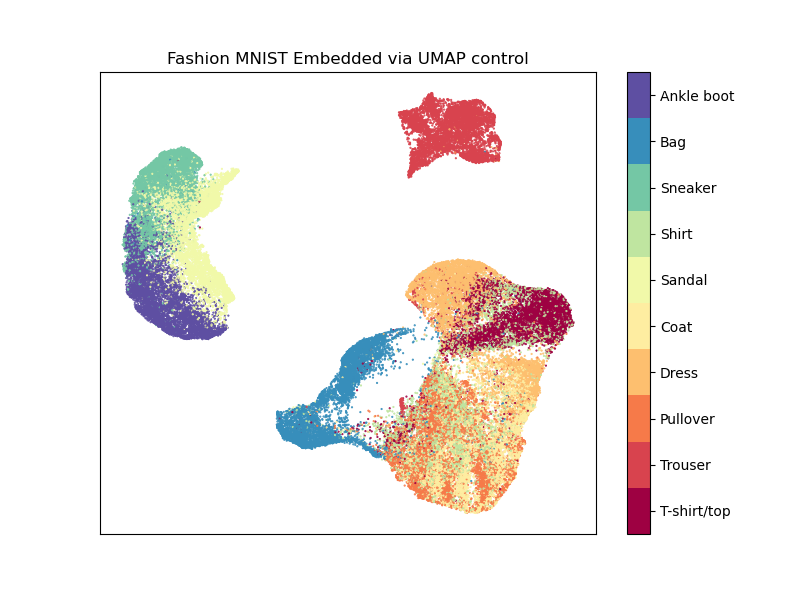

In [52]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP control');

In [56]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=3, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_control_3d = reducer.fit_transform(data)

UMAP(min_dist=0.2, n_components=3, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 10:31:03 2022 Construct fuzzy simplicial set
Wed Sep  7 10:31:03 2022 Finding Nearest Neighbors
Wed Sep  7 10:31:03 2022 Building RP forest with 18 trees
Wed Sep  7 10:31:04 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 10:31:07 2022 Finished Nearest Neighbor Search
Wed Sep  7 10:31:07 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 10:33:04 2022 Finished embedding


In [7]:
def rotate(angle,image):
    # Define the most occuring variables
    angle=math.radians(angle)                               #converting degrees to radians
    cosine=math.cos(angle)
    sine=math.sin(angle)
    height=image.shape[0]                                   #define the height of the image
    width=image.shape[1]                                    #define the width of the image
    
    # Define the height and width of the new image that is to be formed
    new_height  = round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
    new_width  = round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

    # define another image variable of dimensions of new_height and new _column filled with zeros
    output=np.zeros((new_height,new_width))
    print(output.shape)
    # Find the centre of the image about which we have to rotate the image
    original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
    original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

    # Find the centre of the new image that will be obtained
    new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
    new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image
    
    
    for i in range(height):
        for j in range(width):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width 

            #Applying shear Transformation                     
            new_y,new_x=shear(angle,x,y)

            '''since image will be rotated the centre will change too, 
                so to adust to that we will need to change new_x and new_y with respect to the new centre'''
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            output[new_y,new_x]=image[i,j]                          #writing the pixels to the new destination in the output image
    """
    for i in range(height):
        for j in range(width):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width                      

            #co-ordinate of pixel with respect to the rotated image
            new_y=round(-x*sine+y*cosine)
            
            new_x=round(x*cosine+y*sine)

            '''since image will be rotated the centre will change too, 
               so to adust to that we will need to change new_x and new_y with respect to the new centre'''
            
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            # adding if check to prevent any errors in the processing
            if 0 <= new_x < new_width and 0 <= new_y < new_height and new_x>=0 and new_y>=0:
                output[new_y,new_x]=image[i,j]
    """
    
    return output           

In [8]:
# sheering the data in a special way here ensures that there are not problems with anti alising 
def shear(angle,x,y):
    '''
    |1  -tan(𝜃/2) |  |1        0|  |1  -tan(𝜃/2) | 
    |0      1     |  |sin(𝜃)   1|  |0      1     |
    '''
    # shear 1
    tangent=math.tan(angle/2)
    new_x=round(x-y*tangent)
    new_y=y
    
    #shear 2
    new_y=round(new_x*math.sin(angle)+new_y)      #since there is no change in new_x according to the shear matrix

    #shear 3
    new_x=round(new_x-new_y*tangent)              #since there is no change in new_y according to the shear matrix
    
    return new_y,new_x

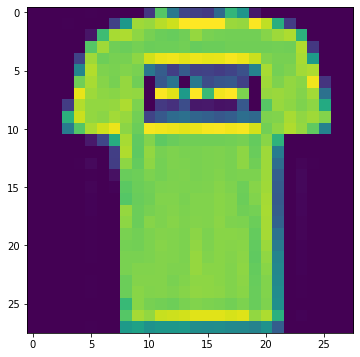

(41, 41)
(41, 41)
<class 'numpy.ndarray'>


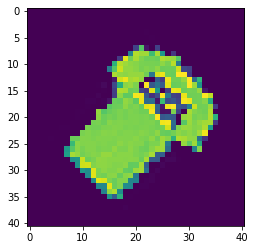

In [40]:
#testing rotations on sample image 


l=np.reshape(data[1],(28,28))
fig = plt.figure( figsize=(8, 6))
plt.imshow(l, cmap='viridis')
plt.show()

#fails for 5,6 degrees
i=rotate(45,l)
print(i.shape)

print(type(i))
plt.imshow(i, cmap='viridis')
plt.show()


## Rotating 45 degrees

In [27]:
#rotating all of the data by 45deg
theta=45
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r45_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r45_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 100.0%


In [28]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r45 = reducer.fit_transform(r45_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 09:32:51 2022 Construct fuzzy simplicial set
Wed Sep  7 09:32:51 2022 Finding Nearest Neighbors
Wed Sep  7 09:32:51 2022 Building RP forest with 18 trees
Wed Sep  7 09:32:53 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 09:32:56 2022 Finished Nearest Neighbor Search
Wed Sep  7 09:32:56 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 09:34:43 2022 Finished embedding


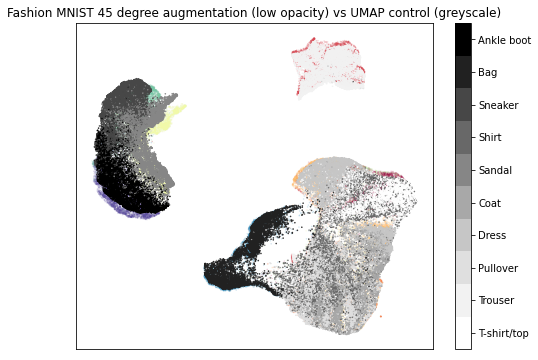

In [36]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(*embedding_r45.T, s=0.3, c=target, cmap='Spectral', alpha=.2)
plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 45 degree augmentation (low opacity) vs UMAP control (greyscale)');

## Rotating 30 degrees

In [12]:
#rotating all of the data by 30deg
theta=30
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r30_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r30_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 100.0%


In [11]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r30 = reducer.fit_transform(r30_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 08:45:16 2022 Construct fuzzy simplicial set
Wed Sep  7 08:45:16 2022 Finding Nearest Neighbors
Wed Sep  7 08:45:16 2022 Building RP forest with 18 trees
Wed Sep  7 08:45:18 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 08:45:25 2022 Finished Nearest Neighbor Search
Wed Sep  7 08:45:28 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 08:47:16 2022 Finished embedding


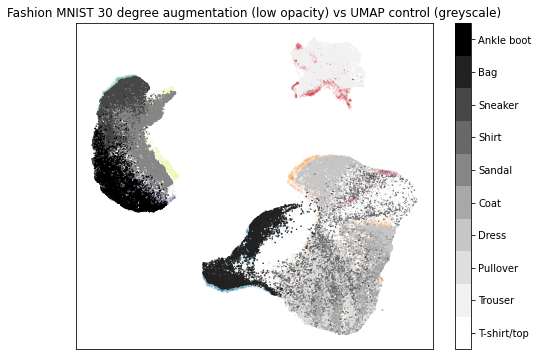

In [38]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(8, 6))
plt.scatter(*embedding_r30.T, s=0.3, c=target, cmap='Spectral', alpha=.1)

plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 30 degree augmentation (low opacity) vs UMAP control (greyscale)');

## Rotating 150 degrees

In [21]:
#rotating all of the data by 150deg
theta=150
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r150_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r150_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 100.0%


In [22]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r150 = reducer.fit_transform(r150_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 09:20:42 2022 Construct fuzzy simplicial set
Wed Sep  7 09:20:43 2022 Finding Nearest Neighbors
Wed Sep  7 09:20:43 2022 Building RP forest with 18 trees
Wed Sep  7 09:20:45 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 09:20:47 2022 Finished Nearest Neighbor Search
Wed Sep  7 09:20:48 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 09:22:39 2022 Finished embedding


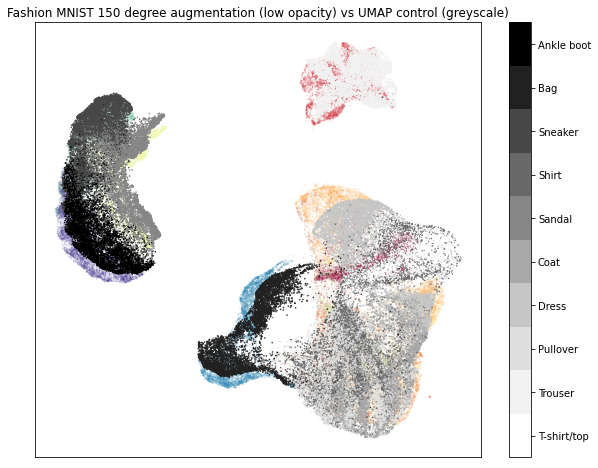

In [39]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding_r150.T, s=0.3, c=target, cmap='Spectral', alpha=.2)

plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 150 degree augmentation (low opacity) vs UMAP control (greyscale)');

## Rotating 200 degrees

In [30]:
#rotating all of the data by 200deg
theta=200
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r200_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r200_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 100.0%


In [31]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r200 = reducer.fit_transform(r200_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 09:38:27 2022 Construct fuzzy simplicial set
Wed Sep  7 09:38:27 2022 Finding Nearest Neighbors
Wed Sep  7 09:38:27 2022 Building RP forest with 18 trees
Wed Sep  7 09:38:29 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 09:38:32 2022 Finished Nearest Neighbor Search
Wed Sep  7 09:38:32 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 09:40:19 2022 Finished embedding


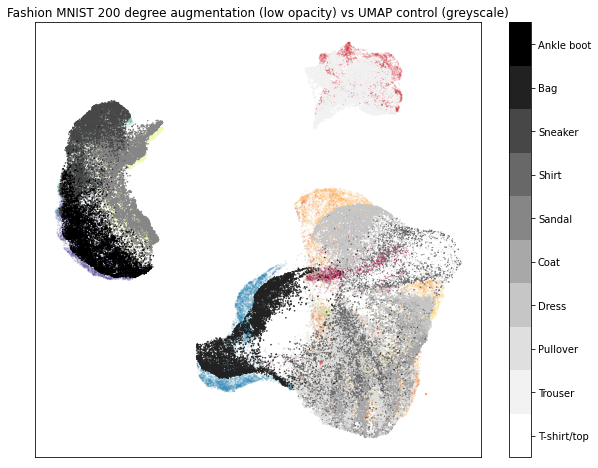

In [35]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding_r200.T, s=0.3, c=target, cmap='Spectral', alpha=.2)

plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 200 degree augmentation (low opacity) vs UMAP control (greyscale)');

In [33]:
# notably worse invariance on high rotation degree

In [41]:
## Rotating 280 degrees 

In [42]:
#rotating all of the data by 200deg
theta=280
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r280_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r280_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 100.0%


In [43]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r280 = reducer.fit_transform(r280_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 09:49:24 2022 Construct fuzzy simplicial set
Wed Sep  7 09:49:24 2022 Finding Nearest Neighbors
Wed Sep  7 09:49:24 2022 Building RP forest with 18 trees
Wed Sep  7 09:49:25 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 09:49:28 2022 Finished Nearest Neighbor Search
Wed Sep  7 09:49:28 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 09:51:14 2022 Finished embedding


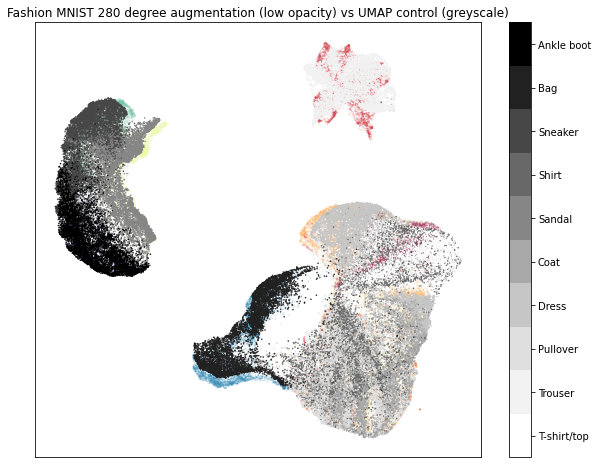

In [44]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding_r280.T, s=0.3, c=target, cmap='Spectral', alpha=.2)

plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 280 degree augmentation (low opacity) vs UMAP control (greyscale)');

In [45]:
## Rotating 90 degrees

In [47]:
#rotating all of the data by 200deg
theta=90
temp=rotate(theta,np.reshape(data[1],(28,28)))

sample_rotation_dim=np.matrix.flatten(temp).shape[0]
r90_data=np.zeros((data.shape[0],sample_rotation_dim))

for i in range(np.shape(data)[0]):
        temp=rotate(theta,np.reshape(data[i],(28,28)));
        r90_data[i]=np.matrix.flatten(temp);
        update_progress(i / np.shape(data)[0])
        

Progress: [####################] 100.0%


In [48]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=2, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r90 = reducer.fit_transform(r90_data)

UMAP(min_dist=0.2, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 09:57:25 2022 Construct fuzzy simplicial set
Wed Sep  7 09:57:26 2022 Finding Nearest Neighbors
Wed Sep  7 09:57:26 2022 Building RP forest with 18 trees
Wed Sep  7 09:57:27 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 09:57:29 2022 Finished Nearest Neighbor Search
Wed Sep  7 09:57:30 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 09:59:18 2022 Finished embedding


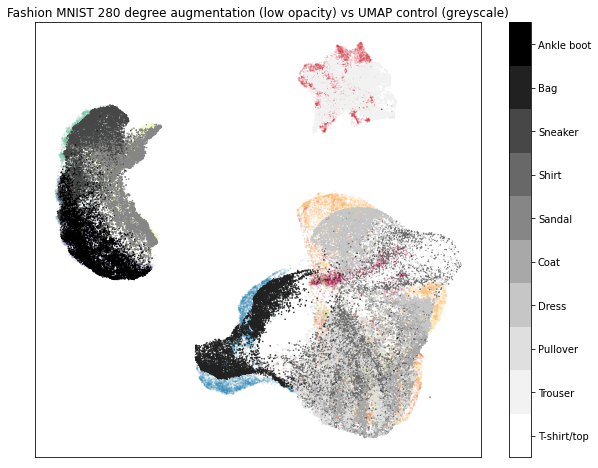

In [49]:
target = np.hstack([train_labels, test_labels])

fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding_r90.T, s=0.3, c=target, cmap='Spectral', alpha=.2)

plt.scatter(*embedding_control_2d.T, s=0.3, c=target, cmap='Greys', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST 280 degree augmentation (low opacity) vs UMAP control (greyscale)');

In [50]:
reducer = umap.UMAP(random_state=42,n_epochs=epochs,n_components=3, n_neighbors=neighbors,min_dist=dist,verbose=1)
embedding_r90_3d = reducer.fit_transform(r90_data)

UMAP(min_dist=0.2, n_components=3, n_epochs=500, random_state=42, verbose=1)
Wed Sep  7 09:59:47 2022 Construct fuzzy simplicial set
Wed Sep  7 09:59:47 2022 Finding Nearest Neighbors
Wed Sep  7 09:59:47 2022 Building RP forest with 18 trees
Wed Sep  7 09:59:48 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Sep  7 09:59:51 2022 Finished Nearest Neighbor Search
Wed Sep  7 09:59:51 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Sep  7 10:01:47 2022 Finished embedding


<IPython.core.display.Javascript object>


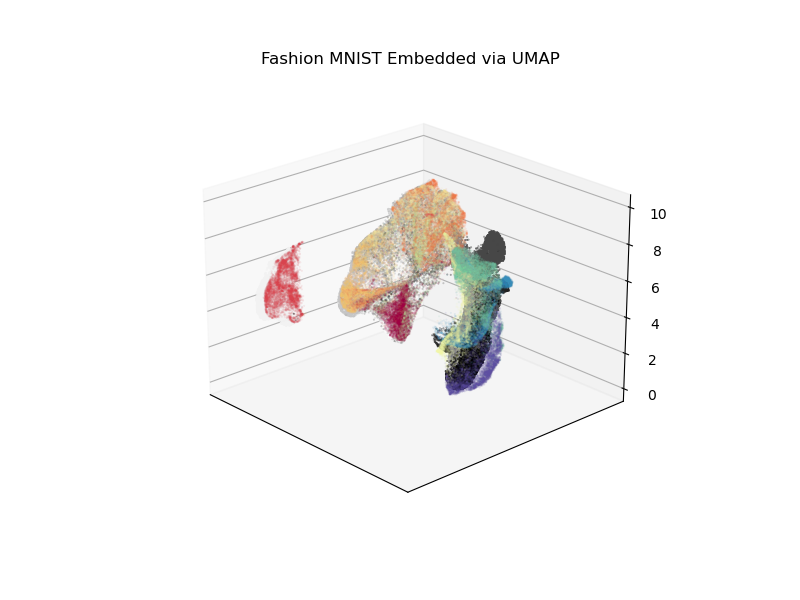

In [57]:
%matplotlib notebook

fig = plt.figure( figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*embedding_control_3d.T, c=target, s=.2,cmap='Greys')
ax.scatter(*embedding_r90_3d.T, c=target, s=.2,cmap='Spectral',alpha=.1)
#plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])

plt.title('Fashion MNIST Embedded via UMAP');